In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/benjs/nfnets_pytorch
!pip install imgaug

In [ ]:
!pip install -U scikit-image

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import nn
import shutil

In [5]:
!mkdir /content/datasets
shutil.unpack_archive("/content/drive/MyDrive/DSforBiz/Character_Images.zip", "/content/datasets", 'zip')

In [6]:
shutil.copy("/content/drive/MyDrive/DSforBiz/Labels.txt","/content/datasets")

'/content/datasets/Labels.txt'

## Data Augmentation

We apply the `imgaug` library for diverse data augmentation. Considering that the test set is not very different from the training set in terms of shape, we only made smaller adjustments in the shape. However, we performed data enhancement on the sharpness, light and shadow, of the images. Also to ensure the diversity of data enhancement, we randomly apply the augmentation sequence to each image.

[Reference]
https://imgaug.readthedocs.io/en/latest/

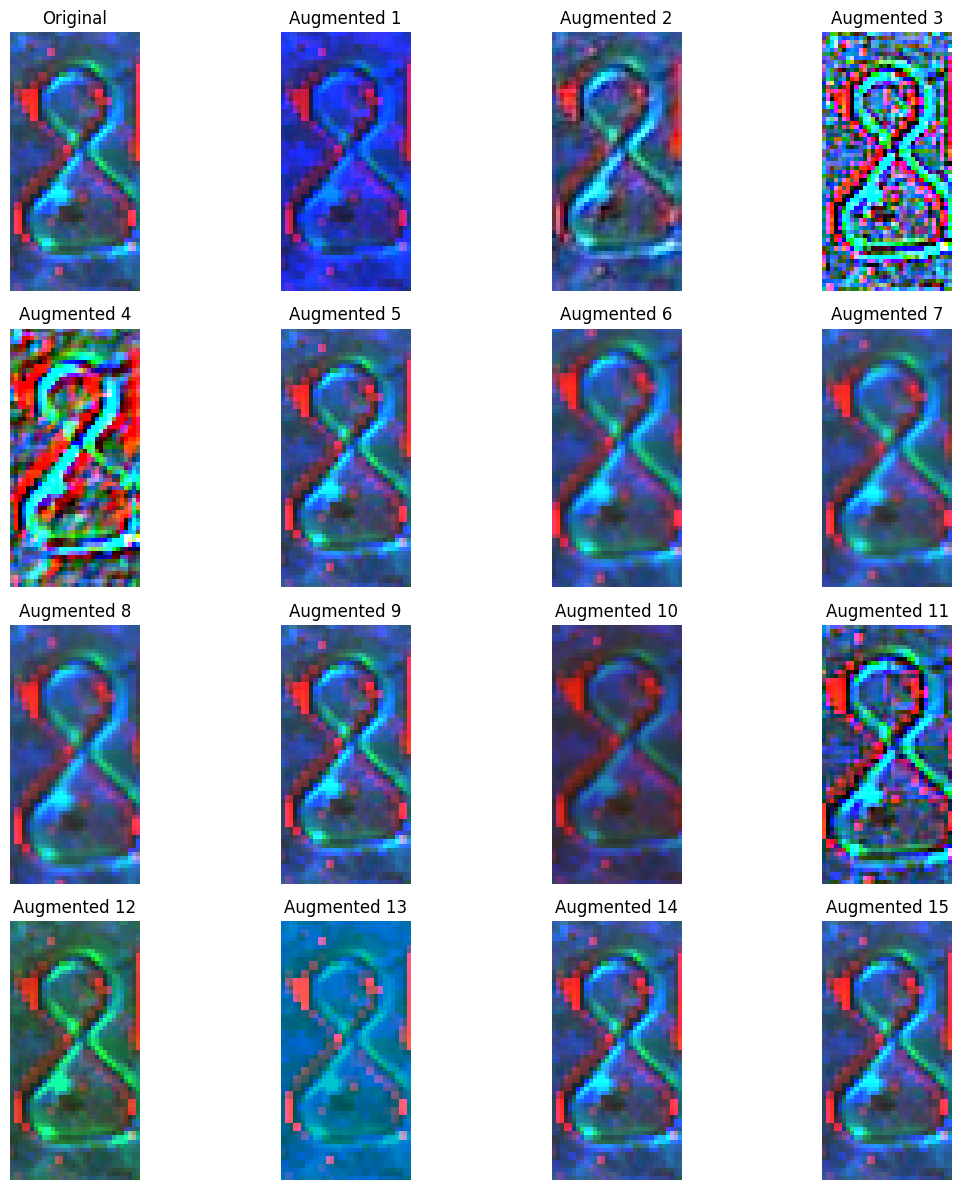

In [7]:
import imgaug as ia
import imgaug.augmenters as iaa
import imageio
import matplotlib.pyplot as plt


image = imageio.v2.imread('/content/datasets/Character_Images/sample_00222.png')

# Sometimes(0.2, ...) applies the given augmenter in 20% of all cases,
sometimes = lambda aug: iaa.Sometimes(0.2, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 3 of the following (less important) augmenters per
        # image.
        #
        iaa.SomeOf((0, 3),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 1.0),
                # average/uniform blur (kernel size between 1x1 and 2x2)
                # median blur (kernel size between 3x3 and 7x7).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)),
                    iaa.AverageBlur(k=(1, 2)),
                    # iaa.MedianBlur(k=(3, 7)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.3
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Compress images
                iaa.JpegCompression(compression=(20, 40)),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Add saturation
                iaa.AddToSaturation((-20, 20)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

augmented_images = [seq.augment_image(image) for _ in range(15)]


plt.figure(figsize=(12, 12))

# Show the original image
plt.subplot(4, 4, 1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

# show the augmentated images
for i, aug_img in enumerate(augmented_images, 2):
    plt.subplot(4, 4, i)
    plt.imshow(aug_img)
    plt.title(f"Augmented {i-1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Experimental Setup
1. Load the data and labels and keep them in a proper format in the memory
2. Split the dataset
3. Data augmentation on training set
4. Define dataloaders

In [8]:
# Path to the folder and labels file
image_folder = '/content/datasets/Character_Images'
labels_file = '/content/datasets/Labels.txt'
augmented_folder = '/content/datasets/Aug_Character_images'

# Function to convert character to integer label
def char_to_label(ch):
    if ch.isdigit():
        return int(ch)
    elif ch == 'C':
        return 10  # 'C' mapped to 10
    elif ch == 'E':
        return 11  # 'E' mapped to 11
    else:
        return 12  # 'X' mapped to 12

# Read labels
labels = {}
with open(labels_file, 'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        labels[key.strip()] = char_to_label(value.strip())


In [9]:
!mkdir /content/datasets/Aug_Character_images

In [10]:
# Split into training and testing sets
train_filenames, test_filenames = train_test_split(
    [f for f in os.listdir(image_folder) if f.endswith('.png')],
    test_size=0.2, random_state=42
)

# Ensure the augmented images directory exists
if not os.path.exists(augmented_folder):
    os.makedirs(augmented_folder)

# Apply augmentations to images in the training set
for filename in train_filenames:
    img_path = os.path.join(image_folder, filename)
    image = imageio.v2.imread(img_path)

    # Copy the original image to the augmented folder
    shutil.copy(img_path, os.path.join(augmented_folder, filename))

    # Apply augmentation to training set images
    for i in range(3):  # Number of augmented versions to create
        augmented_image = seq.augment_image(image)
        augmented_image_path = os.path.join(augmented_folder, f"{filename[:-4]}_aug_{i}.png")
        imageio.imwrite(augmented_image_path, augmented_image)

        # Add new labels for augmented images
        labels[f"{filename[:-4]}_aug_{i}"] = labels[filename[:-4]]

# Update the labels file with new entries for augmented images
with open(labels_file, 'w') as file:
    for key, value in labels.items():
        file.write(f"{key}, {value}\n")

# Custom Dataset class
class CharacterDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((32, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
train_paths = [os.path.join(augmented_folder, f) for f in os.listdir(augmented_folder) if f.endswith('.png')]
train_labels = [labels[os.path.splitext(f)[0]] for f in os.listdir(augmented_folder) if f.endswith('.png')]
test_paths = [os.path.join(image_folder, f) for f in test_filenames]
test_labels = [labels[f[:-4]] for f in test_filenames]

train_dataset = CharacterDataset(train_paths, train_labels, transform=transform)
test_dataset = CharacterDataset(test_paths, test_labels, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model
We apply the LeNet CNN structure and transform the convolution layer into scaled weight standardisation convolutions by replacing all the  `nn.Conv2d` with `WSConv2D`and all `nn.ReLU` with `VPReLU`, which drawing upon the NF Net.
We have four convolutional layers and a pooling layers with a kernel size of 2 and a stride of 2, reducing the spatial dimensions of the input. To avoid problems with size mismatches, we chose not to perform a third pooling.

[Reference]
1. **LeNet**: Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.
2. **NFNet**: https://github.com/benjs/nfnets_pytorch

In [11]:
import collections.abc
collections.Iterable = collections.abc.Iterable
from nfnets import WSConv2D, VPReLU, VPGELU

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.activation = VPReLU(inplace=True)

        self.conv1 = WSConv2D(3, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = WSConv2D(6, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = WSConv2D(16, 32, kernel_size=5, stride=1, padding=0)
        self.conv4 = WSConv2D(32, 64, kernel_size=(1, 5), stride=1, padding=0)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 1 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 13)  # 13 output classes

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = x.view(-1, 64 * 1 * 5)  # Flatten the output for the fully connected layer
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Convert to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, batch_count = 0, 0
    losses = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        if batch_count % 500 == 0:
            current_loss = loss.item()
            current = batch * len(X)
            print(f"loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}]")
            average_loss = total_loss / batch_count
            losses.append(average_loss)
            total_loss, batch_count = 0, 0

    return losses

## Training

Epoch 1
-------------------------------
loss: 0.332413  [31936/239816]
loss: 0.314764  [63936/239816]
loss: 0.212749  [95936/239816]
loss: 0.167926  [127936/239816]
loss: 0.179650  [159936/239816]
loss: 0.202225  [191936/239816]
loss: 0.210841  [223936/239816]
Loss: 0.226995
Epoch 2
-------------------------------
loss: 0.311907  [31936/239816]
loss: 0.299639  [63936/239816]
loss: 0.169686  [95936/239816]
loss: 0.103495  [127936/239816]
loss: 0.160040  [159936/239816]
loss: 0.080601  [191936/239816]
loss: 0.109776  [223936/239816]
Loss: 0.167924
Epoch 3
-------------------------------
loss: 0.051361  [31936/239816]
loss: 0.274746  [63936/239816]
loss: 0.049687  [95936/239816]
loss: 0.052014  [127936/239816]
loss: 0.212506  [159936/239816]
loss: 0.193403  [191936/239816]
loss: 0.172501  [223936/239816]
Loss: 0.145095
Epoch 4
-------------------------------
loss: 0.065159  [31936/239816]
loss: 0.149813  [63936/239816]
loss: 0.274348  [95936/239816]
loss: 0.060930  [127936/239816]
loss: 0

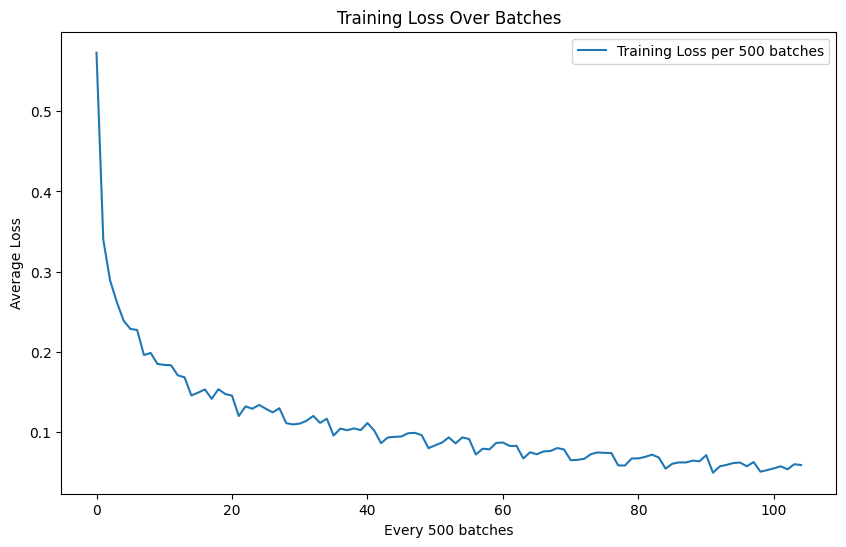

In [12]:
all_losses = []
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_losses = train(train_loader, model, loss_fn, optimizer)
    all_losses.extend(epoch_losses)
    print(f"Loss: {epoch_losses[-1]:>7f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(all_losses, label='Training Loss per 500 batches')
plt.xlabel('Every 500 batches')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.show()

## Report performance and save the NN
Here we report our model performance and save the model for future prediction.

In [13]:
# Function to eval the model
def evaluate_model(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Set the model to evaluation mode
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    return test_loss, correct

# Run the eval function
test_loss, test_accuracy = evaluate_model(test_loader, model)
print(f"Test Loss: {test_loss:>8f}, Test Accuracy: {(100*test_accuracy):>0.1f}%")

Test Loss: 0.012285, Test Accuracy: 99.7%


In [14]:
torch.save(model, '/content/drive/MyDrive/DSforBiz/LeNetPlusNF_4C.pth')

In [15]:
train_loss, train_accuracy = evaluate_model(train_loader, model)
print(f"Training Loss: {train_loss:>8f}, Training Accuracy: {(100*train_accuracy):>0.1f}%")

Training Loss: 0.047523, Training Accuracy: 98.5%
